In [1]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

SEED = 8
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Define the shortest path model class

In [3]:
class ShortestPathModel():

    def __init__(self, grid):
        # grid (tuple): size of grid network
        self.grid = grid
        # arcs/edges of the network
        self.arcs = self.getArcs()
        # creating a network model and its associated edges
        self.model, self.edges = self.getModel()
        # number of edges with cost
        self.num_cost = self.get_num_cost()

    # method to get the list of arcs/edges for the grid network
    def getArcs(self):
        arcs = []
        for i in range(self.grid[0]):
            # edges along the rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges along the columns
            if i == self.grid[0] - 1:
                # no downward column connection at the last row
                continue 
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    # build an optimization model
    def getModel(self):
        # build graph as optimization model
        g = nx.Graph()
        # add arcs as variables
        g.add_edges_from(self.arcs, cost=0)
        return g, g.edges

    # set the optimization objective to minimize the total cost
    def setObj(self, costs):
        for i, e in enumerate(self.arcs):
            self.model.edges[e]["cost"] = costs[i]

    # obtain the optimal solution and objective value
    def solve(self):
        # solve using dijkstra algorithm
        path = nx.shortest_path(self.model, weight="cost", source=0, target=self.grid[0]*self.grid[1]-1)
        # convert path into active edges
        edges = []
        u = 0
        for v in path[1:]:
            edges.append((u,v))
            u = v
        # initial solution and objective
        sol = np.zeros(self.num_cost)
        obj = 0
        # convert active edges into solution and obj
        for i, e in enumerate(self.arcs):
            if e in edges:
                # active edge
                sol[i] = 1 
                # cost of active edge
                obj += self.model.edges[e]["cost"] 
        return sol, obj
    
    # count the number of edges in the network
    def get_num_cost(self):
        # this is also the number of costs to be predicted
        return len(self.arcs)

In [4]:
grid = (3,3)
opt_model = ShortestPathModel(grid=grid)

In [5]:
opt_model.getArcs()

[(0, 1),
 (1, 2),
 (0, 3),
 (1, 4),
 (2, 5),
 (3, 4),
 (4, 5),
 (3, 6),
 (4, 7),
 (5, 8),
 (6, 7),
 (7, 8)]

In [6]:
opt_model.get_num_cost()

12

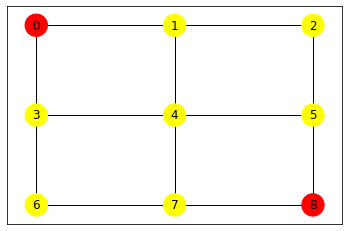

In [7]:
# visualize the graph
# unique nodes in the graph
list_nodes = list(opt_model.model.nodes)

# obtain coordinate for each node in the graph
node_pos = {}
for node in list_nodes:
    node_pos[node] = (int(node%grid[0]), -int(node/grid[1]))

# color the start and sink nodes red and rest yellow
node_col = ['yellow' if not node in [list_nodes[0], list_nodes[-1]] else 'red' for node in list_nodes]
# draw the graphical network
nx.draw_networkx(opt_model.model, node_pos, node_color= node_col, node_size=500)

In [8]:
# solving the 3x3 shortest path problem
opt_model.setObj(costs=[1]*opt_model.get_num_cost())
path = nx.shortest_path(opt_model.model, weight="cost", source=0, target=opt_model.grid[0]*opt_model.grid[1]-1)

In [9]:
path

[0, 1, 2, 5, 8]

# Run the model for 5x5 grid

In [10]:
# grid graph size
grid = (5,5)

# initialize the optimization model
opt_model = ShortestPathModel(grid) 

# set random cost
cost = [random.random() for _ in range(opt_model.get_num_cost())]

# set objective function
opt_model.setObj(cost) 

# solve the optimization model
sol, obj = opt_model.solve()

# store active edges
sol_edges = []
for i, e in enumerate(opt_model.arcs):
    if sol[i] > 1e-3:
        sol_edges.append(e)

In [11]:
print('Obj: {}'.format(obj))
print(sol_edges)

Obj: 1.9975628342989649
[(0, 1), (1, 6), (6, 7), (7, 8), (8, 13), (13, 14), (14, 19), (19, 24)]


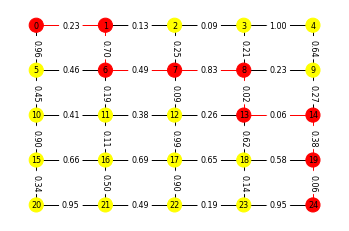

In [12]:
# obtain unique node indices as a list
list_nodes = list(opt_model.model.nodes)

# positional encoding for each node as a dictionary
node_pos = {}
for node in list_nodes:
    node_pos[node] = (int(node%grid[0]), -int(node/grid[1]))

# edge cost as a dictionary
edge_cost = {}
for i, edge in enumerate(list(opt_model.model.edges)):
    edge_cost[edge] = "{:.2f}".format(cost[i])

# selected nodes as a list
sol_nodes = []
for i, j in sol_edges:
    if i not in sol_nodes:
        sol_nodes.append(i)
    if j not in sol_nodes:
        sol_nodes.append(j)

# if the node is in the shortest path, set it to red, else set it to yellow
node_col = ['yellow' if not node in sol_nodes else 'red' for node in list_nodes]

# If the edge is in the shortest path set it to red, else set it to black
edge_col = ['black' if not edge in sol_edges else 'red' for edge in list(opt_model.model.edges)]

# draw the nodes
nx.draw_networkx(opt_model.model, node_pos, node_color= node_col, node_size=200, font_size=8)

# draw the edges
nx.draw_networkx_edges(opt_model.model, node_pos, edge_color = edge_col)

# draw the edge labels
nx.draw_networkx_edge_labels(opt_model.model, node_pos, edge_labels=edge_cost, font_size=8)

# show the plot
plt.axis('off')
plt.figure(1, figsize=(200, 200))
plt.show()

# Define the SPO+ loss function

## Test code for one example

In [13]:
from torch.autograd import Function

class SPOPlusFunc(Function):
    # decorate as static method that belongs to the class only
    @staticmethod
    # forward pass for SPO+
    def forward(ctx, pred_cost, true_cost, true_sol, true_obj,
                optmodel):
        # obtain SPO+ loss and suggested traveling path by solving an optimization model 
        sol, loss = solve_in_forward(pred_cost, true_cost, true_sol, true_obj, optmodel)
        # convert to tensor
        loss = np.array(loss)      
        loss = torch.FloatTensor(loss)
        sol = np.array(sol)
        sol = torch.FloatTensor(sol)
        # save solutions for backward pass
        ctx.save_for_backward(true_sol, sol)
        # add other objects to ctx
        ctx.optmodel = optmodel
        return loss

    @staticmethod
    # backward pass for SPO+
    def backward(ctx, grad_output):
        # extract saved objects from forward()
        w, wq = ctx.saved_tensors
        optmodel = ctx.optmodel
        # calculate the analytical subgradient in closed-form
        grad = 2 * (w - wq)
        # multiply the gradient wrt input with gradient wrt output using the chain rule
        return grad_output * grad, None, None, None, None

# function to solve optimization in the forward pass
def solve_in_forward(cp, c, w, z, optmodel):
    cp = np.array(cp)
    c = np.array(c)
    # use the new cost 2*pred_cost-true_cost in the optimization model
    new_cost = 2 * cp - c
    # shifting all edge costs upwards to make them positive, or zero
    if np.min(new_cost)<0:
        new_cost = new_cost + np.abs(np.min(new_cost))
    # assign the new cost to the optimization model instance
    optmodel.setObj(new_cost)
    # perform optimization to obtain optimal traveling solution and total cost
    solq, objq = optmodel.solve()
    # calculate SPO+ loss
    loss = -objq + 2 * np.dot(cp, w) - z
    
    return solq, loss


In [14]:
from torch import nn

class SPOPlus(nn.Module):
    def __init__(self, optmodel, dataset=None):
        super().__init__()
        self.optmodel = optmodel
        self.spop = SPOPlusFunc()

    def forward(self, pred_cost, true_cost, true_sol, true_obj):
        loss = self.spop.apply(pred_cost, true_cost, true_sol, true_obj,
                               self.optmodel)
        return loss


In [15]:
spop = SPOPlus(opt_model)
pred_cost = [random.random() for _ in range(opt_model.get_num_cost())]
loss = spop(pred_cost, cost, sol, obj)
loss

tensor(2.1182)

# End-to-end training

## Prepare data

In [16]:
# Synthetic data for Shortest path problem
def genData(num_data, num_features, grid, deg=1, noise_width=0, seed=135):
    """
    A function to generate synthetic data and features for shortest path
    Args:
        num_data (int): number of data points
        num_features (int): dimension of features
        grid (int, int): size of grid network
        deg (int): data polynomial degree
        noise_width (float): half witdth of data random noise
        seed (int): random seed
    Returns:
       tuple: data features (np.ndarray), costs (np.ndarray)
    """
    # set seed
    np.random.seed(seed)
    # number of data points
    n = num_data
    # dimension of features
    p = num_features
    # dimension of the cost vector
    d = (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0]
    # random matrix parameter B
    B = np.random.binomial(1, 0.5, (d, p))
    # feature vectors
    x = np.random.normal(0, 1, (n, p))
    # cost vectors
    c = np.zeros((n, d))
    for i in range(n):
        # cost without noise
        ci = (np.dot(B, x[i].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
        # rescale
        ci /= 3.5 ** deg
        # noise
        epislon = np.random.uniform(1 - noise_width, 1 + noise_width, d)
        ci *= epislon
        c[i, :] = ci

    return x, c

In [17]:
# generate data for grid network (features and costs)
n = 2000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
feats, costs = genData(n, p, grid, deg=deg)

In [18]:
# features
print(feats.shape)
print(feats)

(2000, 5)
[[ 0.18978013  0.28131239  0.80407457  0.34358466  0.79699536]
 [-0.89260884  0.22798708  0.40622607  0.20233536  0.44483962]
 [ 0.09901204  0.69809107 -0.25065277  0.08962057  0.7150901 ]
 ...
 [-0.80436654  0.25590744 -0.14672173 -0.41275959  1.28220286]
 [ 0.20511618 -1.79636601  1.55571123  0.11183987 -0.56605091]
 [ 0.35470335 -0.90784318 -0.384665    0.20299626  0.20231918]]


In [19]:
# cost coefficients
print(costs.shape)
print(costs)

(2000, 40)
[[1.1196807  1.45837107 0.54643898 ... 0.98651383 0.99008207 0.85559908]
 [0.47167426 0.9868889  0.54643898 ... 0.79780845 0.78138255 0.68954997]
 [0.90154675 1.02959971 0.54643898 ... 1.16626396 0.70551119 0.47017403]
 ...
 [0.56769133 1.15386747 0.54643898 ... 1.23927857 0.5824488  0.50074203]
 [0.47062148 0.32998715 0.54643898 ... 0.10173785 0.47305124 1.24983587]
 [0.83585924 0.27219742 0.54643898 ... 0.35273756 0.23596431 0.43287876]]


In [20]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=SEED)

In [21]:
# optDataset class based on PyTorch Dataset
from torch.utils.data import Dataset
import time
from tqdm import tqdm

class optDataset(Dataset):
    """
    This class is Torch Dataset for optimization problems.
    Attributes:
        model: Optimization models
        feats: Data features
        costs: Cost vectors
        sols: Optimal solutions
        objs: Optimal objective values
    """

    def __init__(self, model, feats, costs):
        """
        A method to create a optDataset from optModel
        Args:
            model: an instance of optModel
            feats: data features
            costs: costs of objective function
        """
        self.model = model
        # data
        self.feats = feats
        self.costs = costs
        # find optimal solutions
        self.sols, self.objs = self.getSols()

    def getSols(self):
        """
        A method to get optimal solutions for all cost vectors
        """
        sols = []
        objs = []
        print("Optimizing for optDataset...")
        time.sleep(1)
        for c in tqdm(self.costs):
            sol, obj = self.solve(c)
            sols.append(sol)
            objs.append([obj])
        return np.array(sols), np.array(objs)

    def solve(self, cost):
        """
        A method to solve optimization problem to get an optimal solution with given cost
        Args:
            cost (np.ndarray): cost of objective function
        Returns:
            tuple: optimal solution (np.ndarray) and objective value (float)
        """
        self.model.setObj(cost)
        sol, obj = self.model.solve()
        return sol, obj

    def __len__(self):
        """
        A method to get data size
        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)

    def __getitem__(self, index):
        """
        A method to retrieve data
        Args:
            index (int): data index
        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]),
            torch.FloatTensor(self.costs[index]),
            torch.FloatTensor(self.sols[index]),
            torch.FloatTensor(self.objs[index]),
        )


In [22]:
# get optDataest by computing optimal solution for each cost vector
dataset_train = optDataset(opt_model, x_train, c_train)
dataset_test = optDataset(opt_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 5862.91it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 5809.56it/s]


In [23]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Single layer linear model

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training with SPO+ loss

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [27]:
class SPOPlus(nn.Module):
    """
    A autograd module for SPO+ Loss, as a surrogate loss function of SPO Loss,
    which measures the decision error of optimization problem.
    For SPO/SPO+ Loss, the objective function is linear and constraints are
    known and fixed, but the cost vector need to be predicted from contextual
    data.
    The SPO+ Loss is convex with subgradient. Thus, allows us to design an
    algorithm based on stochastic gradient descent.
    """

    def __init__(self, optmodel, processes=1, solve_ratio=1, dataset=None):
        """
        Args:
            optmodel (optModel): an PyEPO optimization model
            processes (int): number of processors, 1 for single-core, 0 for all of cores
            solve_ratio (float): the ratio of new solutions computed during training
            dataset (None/optDataset): the training data
        """
        super().__init__()
        # optimization model
        self.optmodel = optmodel
        # num of processors
        self.processes = processes
        print("Num of cores: {}".format(self.processes))
        # solution pool
        self.solve_ratio = solve_ratio
        self.solpool = None
        # build carterion
        self.spop = SPOPlusFunc()

    def forward(self, pred_cost, true_cost, true_sol, true_obj):
        """
        Forward pass
        """
        loss = self.spop.apply(pred_cost, true_cost, true_sol, true_obj,
                               self.optmodel, self.processes, self.solve_ratio,
                               self)
        return loss



class SPOPlusFunc(Function):
    """
    A autograd function for SPO+ Loss
    """

    @staticmethod
    def forward(ctx, pred_cost, true_cost, true_sol, true_obj,
                optmodel, processes, solve_ratio, module):
        """
        Forward pass for SPO+
        Args:
            pred_cost (torch.tensor): a batch of predicted values of the cost
            true_cost (torch.tensor): a batch of true values of the cost
            true_sol (torch.tensor): a batch of true optimal solutions
            true_obj (torch.tensor): a batch of true optimal objective values
            optmodel (optModel): an PyEPO optimization model
            processes (int): number of processors, 1 for single-core, 0 for all of cores
            solve_ratio (float): the ratio of new solutions computed during training
            module (nn.Module): SPOPlus modeul
        Returns:
            torch.tensor: SPO+ loss
        """
        # get device
        device = pred_cost.device
        # convert tenstor
        cp = pred_cost.detach().to("cpu").numpy()
        c = true_cost.detach().to("cpu").numpy()
        w = true_sol.detach().to("cpu").numpy()
        z = true_obj.detach().to("cpu").numpy()
        # check sol
        #_check_sol(c, w, z)
        # solve
        sol, loss = _solve_in_forward(cp, c, w, z, optmodel, processes)
        if solve_ratio < 1:
            module.solpool = np.concatenate((module.solpool, sol))

        loss = np.array(loss)
        # convert to tensor
        loss = torch.FloatTensor(loss).to(device)
        sol = np.array(sol)
        sol = torch.FloatTensor(sol).to(device)
        # save solutions
        ctx.save_for_backward(true_sol, sol)
        # add other objects to ctx
        ctx.optmodel = optmodel
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass for SPO+
        """
        w, wq = ctx.saved_tensors
        optmodel = ctx.optmodel
        grad = 2 * (w - wq)
        
        return grad_output * grad, None, None, None, None, None, None, None


def _solve_in_forward(cp, c, w, z, optmodel, processes):
    """
    A function to solve optimization in the forward pass
    """
    # number of instance
    ins_num = len(z)
    # single-core

    loss = []
    sol = []
    for i in range(ins_num):
        new_cost = 2 * cp[i] - c[i]
        # print(new_cost)
        # print(np.min(new_cost))
        if np.min(new_cost)<0:
            new_cost = new_cost + np.abs(np.min(new_cost))
            # cp[i] = cp[i] + np.abs(np.min(new_cost))
        # print(new_cost)
        optmodel.setObj(new_cost)

        # solve
        # optmodel.setObj(2 * cp[i] - c[i])
        solq, objq = optmodel.solve()
        objq -= len(solq)*np.abs(np.min(new_cost))
        # calculate loss
        # print(objq)
        loss.append(objq + 2 * np.dot(cp[i], w[i]) - z[i])
        # solution
        sol.append(solq)
    
    return sol, loss


In [28]:
spop = SPOPlus(opt_model)

Num of cores: 1


In [29]:
def regret(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret
    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet
    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        # print("test")
        x, c, w, z = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            cp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(cp.shape[0]):
            # print(cp[j])
            # print(c[j])
            # accumulate loss
            loss += calRegret(optmodel, cp[j], c[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)


def calRegret(optmodel, pred_cost, true_cost, true_obj):
    """
    A function to calculate normalized true regret for a batch
    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values
    Returns:predmodel
        float: true regret losses
    """
    new_cost_pred = pred_cost
    if np.min(new_cost_pred)<0:
        new_cost_pred = new_cost_pred + np.abs(np.min(new_cost_pred))

    # opt sol for pred cost
    optmodel.setObj(new_cost_pred)
    sol, _ = optmodel.solve()
    # obj with true cost
    obj = np.dot(sol, true_cost)
    # loss
    loss = obj - true_obj
    return loss

In [30]:
# train model
num_epochs = 50
reg.train()
# init log
loss_log = []
loss_log_regret = [regret(reg, opt_model, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # for obs_idx, (obs_cp, obs_c, obs_w, obs_z) in enumerate(zip(cp, c, w, z)):
        #     loss += spop(obs_cp, obs_c, obs_w, obs_z)
        # loss /= len(data)
        # print(loss)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log.append(loss.item())
    batch_regret = regret(reg, opt_model, loader_test)
    loss_log_regret.append(batch_regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), batch_regret*100))

Epoch   1, Loss:   7.9939, Regret:  4.1036%
Epoch   2, Loss:   5.2713, Regret:  0.8524%
Epoch   3, Loss:   4.6704, Regret:  0.6220%
Epoch   4, Loss:   3.9321, Regret:  0.5403%
Epoch   5, Loss:   2.7494, Regret:  0.4910%
Epoch   6, Loss:   6.4899, Regret:  0.4705%
Epoch   7, Loss:   6.0828, Regret:  0.4228%
Epoch   8, Loss:   5.6708, Regret:  0.4704%
Epoch   9, Loss:   6.0230, Regret:  0.4780%
Epoch  10, Loss:   5.5521, Regret:  0.4830%
Epoch  11, Loss:   6.1488, Regret:  0.4984%
Epoch  12, Loss:   6.8542, Regret:  0.4731%
Epoch  13, Loss:   4.8488, Regret:  0.6913%
Epoch  14, Loss:   4.9232, Regret:  0.4471%
Epoch  15, Loss:   2.5533, Regret:  0.4631%
Epoch  16, Loss:   5.4317, Regret:  0.4155%
Epoch  17, Loss:   4.3595, Regret:  0.5253%
Epoch  18, Loss:   7.7865, Regret:  0.3632%
Epoch  19, Loss:   3.6873, Regret:  0.4908%
Epoch  20, Loss:   8.5261, Regret:  0.5472%
Epoch  21, Loss:   6.1972, Regret:  0.4776%
Epoch  22, Loss:   5.7222, Regret:  0.4837%
Epoch  23, Loss:   1.7684, Regre

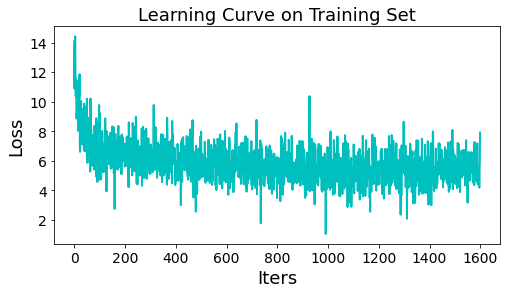

In [31]:
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iters", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Learning Curve on Training Set", fontsize=18)
plt.show()

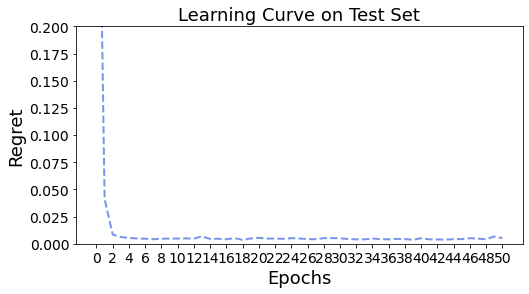

In [32]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
plt.xticks(range(0, num_epochs+1, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 0.2)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Regret", fontsize=18)
plt.title("Learning Curve on Test Set", fontsize=18)
plt.show()